### Import libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
import antropy as ant
import spkit as sp
import seaborn as sns
sns.set()
import EntropyHub as En
import warnings
from vmdpy import VMD
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

### Read and preprocess data

In [11]:
EEG_78_CH2 = pd.read_csv('EEG_78_CH2.csv')
bis_78 = pd.read_csv('bis_78.csv')
B78=bis_78['BIS/BIS']
E78=EEG_78_CH2['BIS/EEG2_WAV']
print ('The shape of EEG signals and BIS for patient 78 is {} and {} '.format(E78.shape,B78.shape) )
print ('The type of EEG signals and BIS for patient 78 is {} and {} '.format(type(E78),type(B78)) )

The shape of EEG signals and BIS for patient 78 is (535191,) and (4180,) 
The type of EEG signals and BIS for patient 78 is <class 'pandas.core.series.Series'> and <class 'pandas.core.series.Series'> 


In [12]:
#checking for missing values

def missing_values(eeg_signal):

    # Check for missing values
    missing_values = np.isnan(eeg_signal)
    length_signals = len(eeg_signal)

    # Count the number of missing values
    num_missing_values = np.sum(missing_values)
    percentage_missing_values = (num_missing_values/length_signals)*100

    # Print the indices and values of missing values
    missing_indices = np.where(missing_values)[0]
    missing_values_list = eeg_signal[missing_indices]

    print("Missing Values:")
    print(f"Total Missing Values: {num_missing_values}")
    print(f"Percentage of Missing Values: {percentage_missing_values} %")  
missing_values(E78)

Missing Values:
Total Missing Values: 167
Percentage of Missing Values: 0.03120381321808476 %


In [13]:
E78_copy = np.copy(E78)

In [14]:
# Handling missing values

def handle_missing_values(signal):
    # Interpolate missing values using linear interpolation
    mask = np.isnan(signal)
    signal[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), signal[~mask])
    return signal
E78_copy=handle_missing_values(E78_copy)

### Selecting EEG signals

In [15]:
import numpy as np

# Assuming BIS and EEG are numpy arrays
BIS = B78
EEG = E78_copy

# Define the sampling frequency
fs = 128

# Define the indices for BIS range from 200 to 800
bis_start_index = 200
bis_end_index = 800

# Convert the BIS indices to EEG indices

eeg_start_index = bis_start_index * fs
eeg_end_index = bis_end_index * fs

# Select EEG values for BIS[200:800]
selected_EEG = EEG[eeg_start_index:eeg_end_index]
selected_bis = BIS[bis_start_index:bis_end_index]
selected_bis = np.array(selected_bis)
print(selected_EEG)


[-14.8  -12.6  -13.1  ... -21.3  -21.8  -20.45]


### Bandpass filtering

In [16]:
# Define the EEG signal
eeg_signal = selected_EEG # Replace with your actual EEG signal


# Define the filter function
def bandpass_filter(signal, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# time in seconds
time = np.arange(len(eeg_signal)) / fs

# Apply bandpass filters to the EEG signal
bpass = bandpass_filter(eeg_signal, 0.01, 63.5, fs=128)




### Variational Mode Decomposition (VMD)

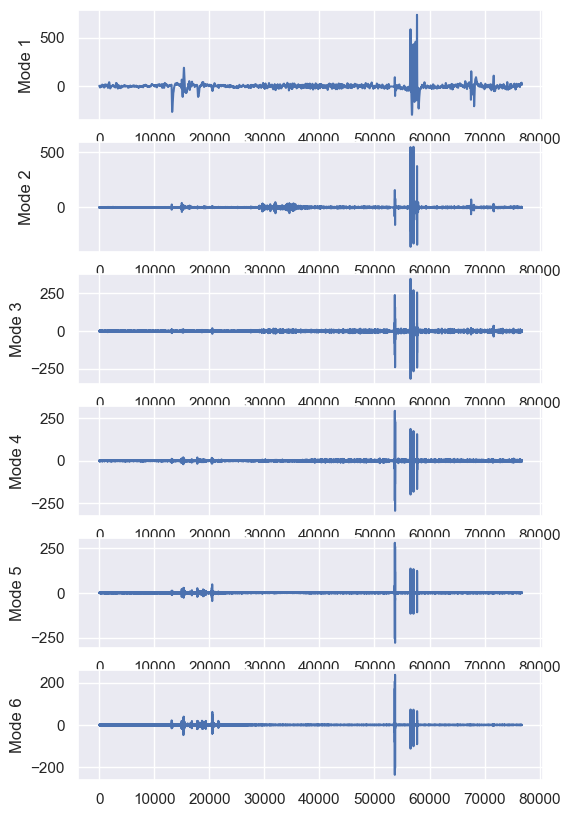

In [18]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 100
tau = 0.5
K = 6
DC = 0
init = 1           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

In [9]:
mode1= modes[0]
mode2= modes[1]
mode3=modes[2]
mode4=modes[3]
mode5=modes[4]
Reconstructed_Signal = mode1+mode2+mode3+mode4+mode5
original_signal=signal

In [131]:
def RMSE(signal,Reconstructed_Signal):
    R=np.sqrt(1/80000 * sum((signal - Reconstructed_Signal)**2))
    return R
RMSE(signal, Reconstructed_Signal)

6.543013928283949

In [134]:
def Energy(Reconstructed_Signal, signal):
    E=(sum(Reconstructed_Signal**2) / sum(signal**2)) * 100
    return E
Energy(signal, Reconstructed_Signal)

97.66348890221653

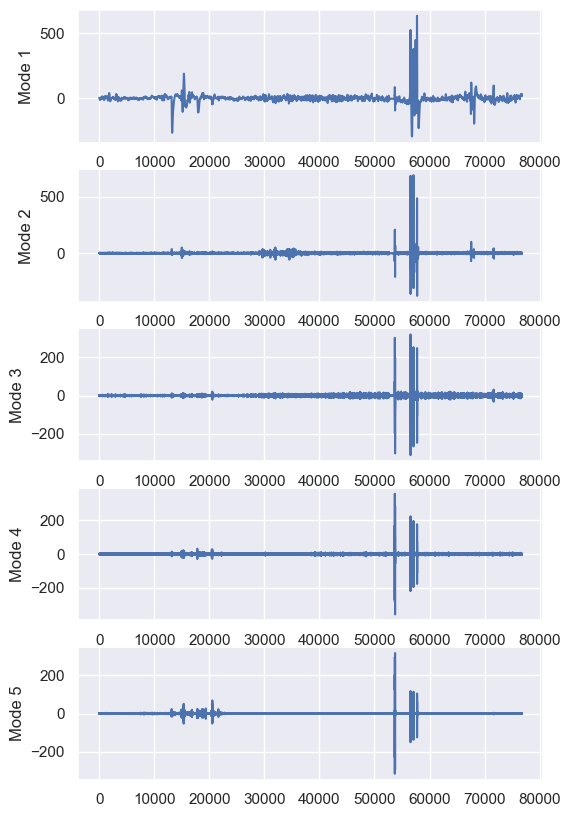

In [286]:


import numpy as np
from vmdpy import VMD

signal = bpass

# Set VMD parameters
alpha = 1000
tau = 0.5
K = 5
DC = 1
init = 0           # initialize omegas uniformly  
tol = 1e-7 

# Run VMD on the signal
modes, spectrum, omega =VMD (signal, alpha, tau, K, DC, init,tol)

#Plot the decomposed modes
import matplotlib.pyplot as plt
fig, axs = plt.subplots(K, 1, figsize=(6, 10))
for i in range(K):
    axs[i].plot(modes[i, :])
    axs[i].set_ylabel(f"Mode {i+1}")
plt.show()

In [287]:
mode1= modes[0]
mode2= modes[1]
mode3=modes[2]
mode4=modes[3]

Reconstructed_Signal = mode1+mode2+mode3+mode4
original_signal=signal

def RMSE(signal,Reconstructed_Signal):
    R=np.sqrt(1/80000 * sum((signal - Reconstructed_Signal)**2))
    return R
RMSE(signal, Reconstructed_Signal)


def Energy(Reconstructed_Signal, signal):
    E=(sum(Reconstructed_Signal**2) / sum(signal**2)) * 100
    return E
Energy(signal, Reconstructed_Signal)

100.71376319810636

In [288]:
def RMSE(signal,Reconstructed_Signal):
    R=np.sqrt(1/80000 * sum((signal - Reconstructed_Signal)**2))
    return R
RMSE(signal, Reconstructed_Signal)

4.584363757767407

In [289]:
import numpy as np

def root_mean_square(predicted_values, observed_values):
    squared_errors = (predicted_values - observed_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    return round(np.sqrt(mean_squared_error),2)


root_mean_square(Reconstructed_Signal, signal)

4.68

For k=2, RMSE= 16.872016305734903 and Energy= 83.32689674486564, rmse=17.219929533736835
For k=3, RMSE= 9.866563157251884 and Energy= 98.59322049202868, rmse= 10.070018854254451
For k=4, RMSE= 9.122054165801819 and Energy= 95.46242256518825
For k=5, RMSE= 6.543013928283949 and Energy= 97.66348890221653
For k=6, RMSE= 3.463853542602731 and Energy= 99.49384816724432
For k=7, RMSE= 2.350913780396323 and Energy=  99.64531764699302
for k=10, RMSE= and Energy=

In [267]:
import numpy as np

def root_mean_square(predicted_values, observed_values):
    squared_errors = (predicted_values - observed_values) ** 2
    mean_squared_error = np.mean(squared_errors)
    return np.sqrt(mean_squared_error)

root_mean_square(Reconstructed_Signal, signal)

3.892298674676178

In [ ]:
mode3=modes[2]
mode4=modes[3]
mode5=modes[4]
mode6=modes[5]
mode7=modes[6]
mode8=modes[7]
mode9=modes[8]
mode10=modes[9]\

+mode4+mode5+mode6+mode7+mode8+mode9+mode10

### Windowing and features extraction

Number of BIS: 545


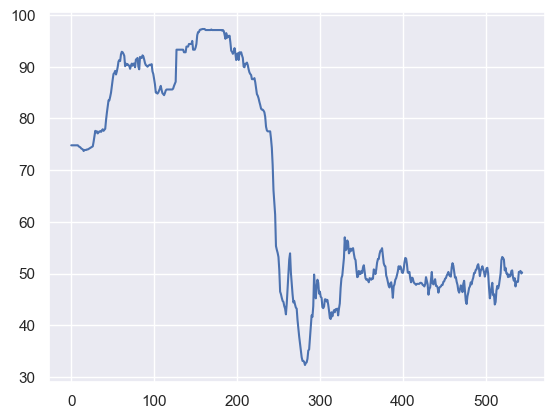

In [9]:


# For BIS

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    windows = []

    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end][0]
        windows.append(window)

    return windows

# Example usage
data = selected_bis  # Sample data
window_size_sec = 56.0       # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 1         # Sampling rate in samples per second

# Apply moving sliding window
bis_windows = moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate)

# Print the number of windows and the shape of the first window
print("Number of BIS:", len(bis_windows))
plt.plot(bis_windows)
plt.show()


In [10]:
#### For entropies

def moving_sliding_window(data, window_size_sec, overlap_sec, sampling_rate, method):
    # Convert window size and overlap from seconds to samples
    window_size = int(window_size_sec * sampling_rate)
    overlap = int(overlap_sec * sampling_rate)

    # Calculate the stride based on the window size and overlap
    stride = window_size - overlap

    # Determine the total number of windows
    num_windows = (len(data) - window_size) // stride + 1

    # Initialize variables
    
    result = []
    
    # Loop over the windows
    for i in range(num_windows):
        window_start = i * stride
        window_end = window_start + window_size
        window = data[window_start:window_end]
        

        if method == "Permutation entropy":
            # Calculate sample entropy within the window
            permutation_entropy = ant.perm_entropy(window)
            result.append(permutation_entropy)
            
        if method == "Dispersion entropy":
            # Calculate sample entropy within the window
            #Dispersion_entropy, prob =En.DispEn(window,classes=2, scale=3, emb_dim=8, delay=2,return_all=False)
            Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=4, emb_dim=8, delay=2,return_all=False)
            result.append(Dispersion_entropy)
            
        if method == "Fuzzy entropy":
            # Calculate sample entropy within the window
            Fuzzy_entropy, prob =En.FuzzEn(window)
            #Dispersion_entropy, prob = sp.dispersion_entropy(window,classes=5, scale=3, emb_dim=5, delay=1,return_all=False)
            result.append(Fuzzy_entropy)
        
         # Detrended Fluctuation
        if method == "detf":
            detf = ant.detrended_fluctuation(window)
            result.append(detf)
            
            
             # Petrosian
        if method == "pet":
            pet = ant.petrosian_fd(window)
            result.append(pet)
            
            
             # hjorth-mobility
        if method == "hm":
            hm = ant.hjorth_params(window)[0]
            result.append(hm)
            
             # hjorth-complex
        if method == "hc":
            hc = ant.hjorth_params(window)[1]
            result.append(hc)
        
    return result


In [11]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultsdt_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='detf')
resultsdt_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='detf')
print(f"Number of features:", len(resultsdt_0))

Number of features: 545


In [12]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultspet_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='pet')
resultspet_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='pet')
print(f"Number of features:", len(resultspet_0))

Number of features: 545


In [13]:



data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshm_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hm')
resultshm_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hm')
print(f"Number of features:", len(resultshm_0))

Number of features: 545


In [14]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]
#data5 = modes[5]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128 


resultshc_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='hc')
resultshc_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='hc')
print(f"Number of features:", len(resultshc_0))

Number of features: 545


In [15]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsp_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')
resultsp_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Permutation entropy')

print(f"Number of features:", len(resultsp_0))


Number of features: 545


In [16]:
data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsd_0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
resultsd_4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Dispersion entropy')
print(f"Number of features:", len(resultsd_0))


Number of features: 545


In [23]:
"""data0 = modes[0]  
data1 = modes[1]
data2 = modes[2]
data3 = modes[3]
data4 = modes[4]

# Sample data
window_size_sec = 56      # Window size in seconds
overlap_sec = 55           # Overlap in seconds
sampling_rate = 128        # Sampling rate in samples per second


# Apply moving sliding window and calculate sample entropies
resultsf0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method='Fuzzy entropy')
resultsf1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method='Fuzzy entropy')
resultsf2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method='Fuzzy entropy')
resultsf3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method='Fuzzy entropy')
resultsf4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method='Fuzzy entropy')
print(f"Number of features:", len(resultsf0))
"""

'data0 = modes[0]  \ndata1 = modes[1]\ndata2 = modes[2]\ndata3 = modes[3]\ndata4 = modes[4]\n\n# Sample data\nwindow_size_sec = 56      # Window size in seconds\noverlap_sec = 55           # Overlap in seconds\nsampling_rate = 128        # Sampling rate in samples per second\n\n\n# Apply moving sliding window and calculate sample entropies\nresultsf0 = moving_sliding_window(data0, window_size_sec, overlap_sec, sampling_rate, method=\'Fuzzy entropy\')\nresultsf1 = moving_sliding_window(data1, window_size_sec, overlap_sec, sampling_rate, method=\'Fuzzy entropy\')\nresultsf2 = moving_sliding_window(data2, window_size_sec, overlap_sec, sampling_rate, method=\'Fuzzy entropy\')\nresultsf3 = moving_sliding_window(data3, window_size_sec, overlap_sec, sampling_rate, method=\'Fuzzy entropy\')\nresultsf4 = moving_sliding_window(data4, window_size_sec, overlap_sec, sampling_rate, method=\'Fuzzy entropy\')\nprint(f"Number of features:", len(resultsf0))\n'

Number of features: 545


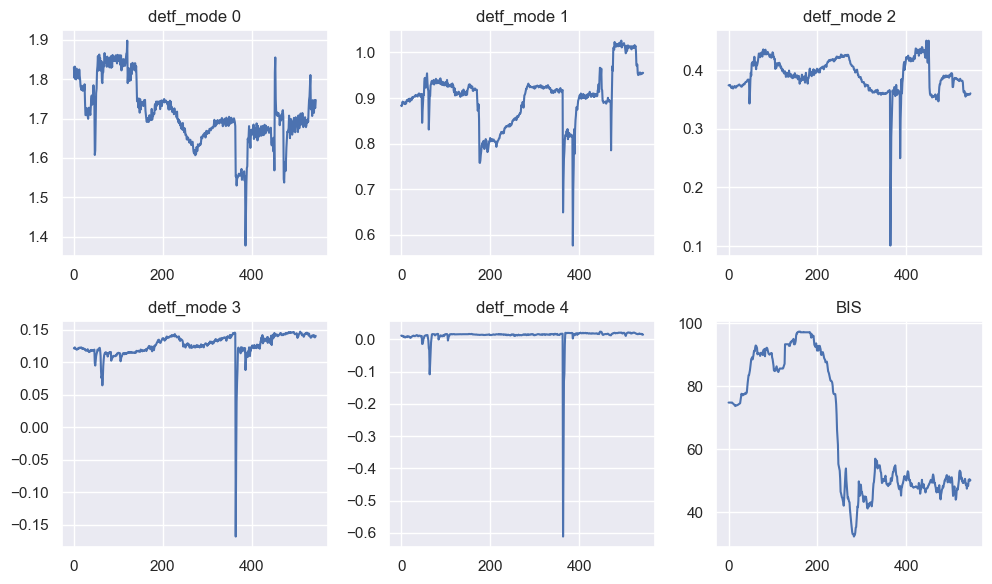

In [17]:
print(f"Number of features:", len(resultsdt_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsdt_0)
axes[0, 0].set_title('detf_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsdt_1)
axes[0, 1].set_title('detf_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsdt_2)
axes[0, 2].set_title('detf_mode 2')

axes[1, 0].plot(resultsdt_3)
axes[1, 0].set_title('detf_mode 3')

axes[1, 1].plot(resultsdt_4)
axes[1, 1].set_title('detf_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 545


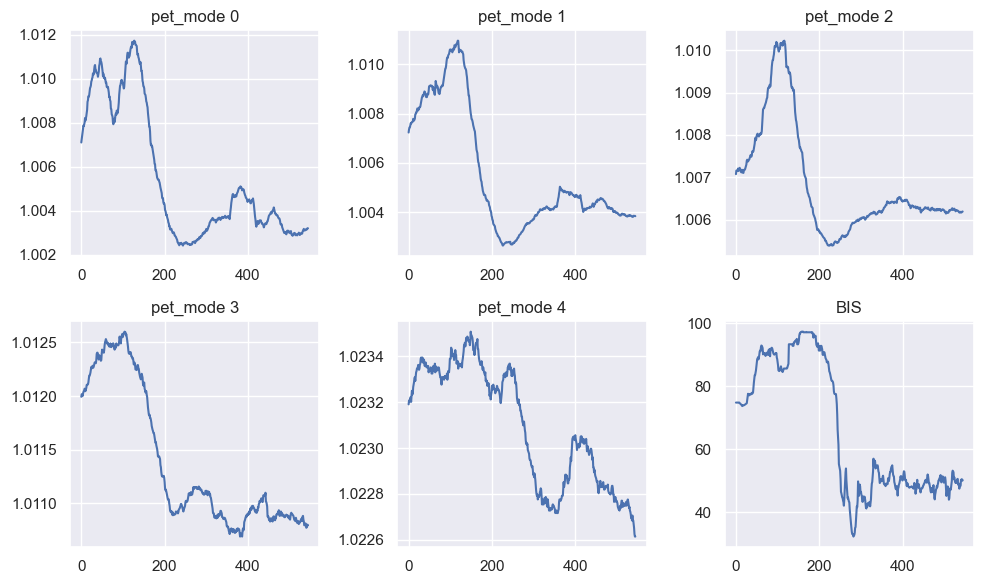

In [18]:
print(f"Number of features:", len(resultspet_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultspet_0)
axes[0, 0].set_title('pet_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultspet_1)
axes[0, 1].set_title('pet_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultspet_2)
axes[0, 2].set_title('pet_mode 2')

axes[1, 0].plot(resultspet_3)
axes[1, 0].set_title('pet_mode 3')

axes[1, 1].plot(resultspet_4)
axes[1, 1].set_title('pet_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 545


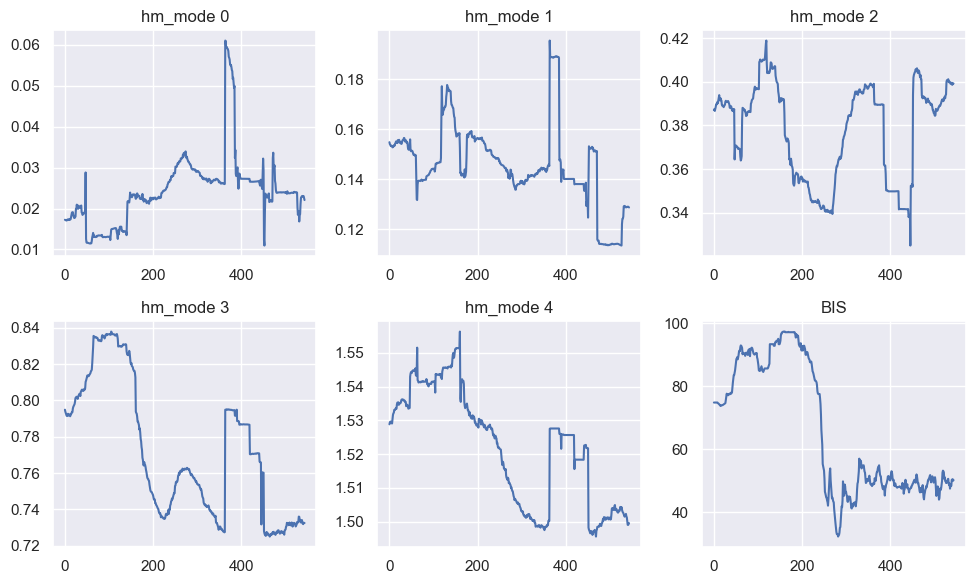

In [19]:
print(f"Number of features:", len(resultshm_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshm_0)
axes[0, 0].set_title('hm_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshm_1)
axes[0, 1].set_title('hm_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshm_2)
axes[0, 2].set_title('hm_mode 2')

axes[1, 0].plot(resultshm_3)
axes[1, 0].set_title('hm_mode 3')

axes[1, 1].plot(resultshm_4)
axes[1, 1].set_title('hm_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 545


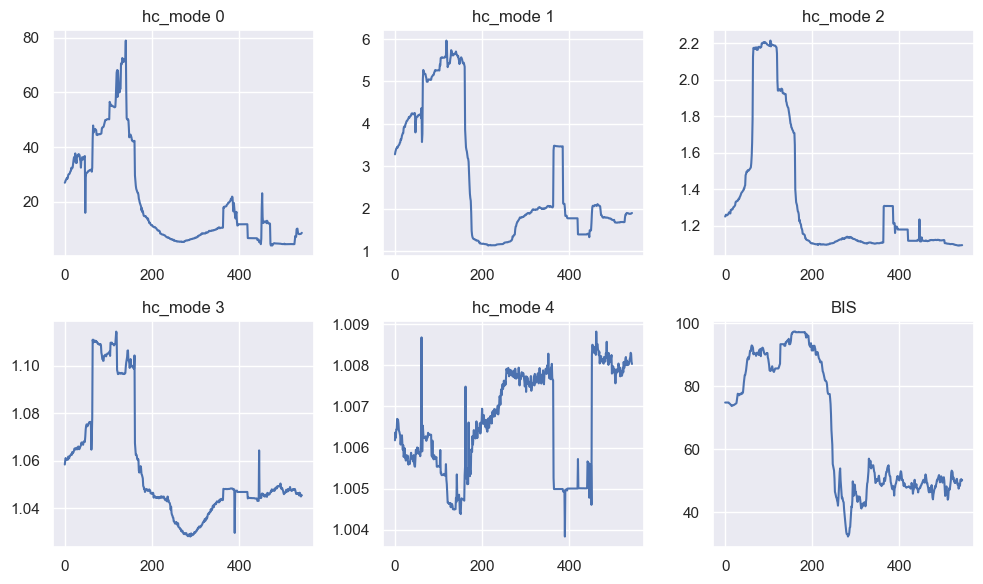

In [20]:
print(f"Number of features:", len(resultshc_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultshc_0)
axes[0, 0].set_title('hc_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultshc_1)
axes[0, 1].set_title('hc_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultshc_2)
axes[0, 2].set_title('hc_mode 2')

axes[1, 0].plot(resultshc_3)
axes[1, 0].set_title('hc_mode 3')

axes[1, 1].plot(resultshc_4)
axes[1, 1].set_title('hc_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 545


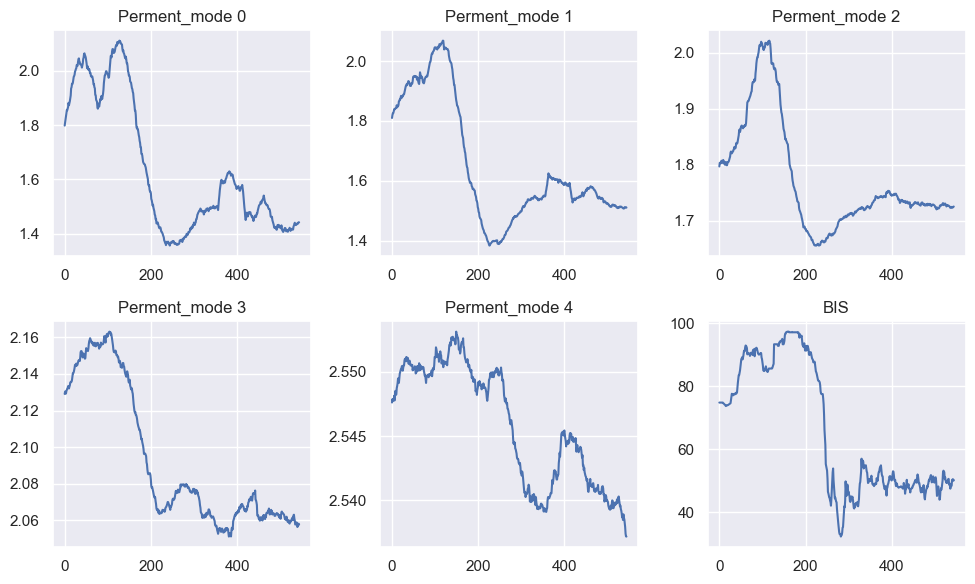

In [21]:
print(f"Number of features:", len(resultsp_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsp_0)
axes[0, 0].set_title('Perment_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsp_1)
axes[0, 1].set_title('Perment_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsp_2)
axes[0, 2].set_title('Perment_mode 2')

axes[1, 0].plot(resultsp_3)
axes[1, 0].set_title('Perment_mode 3')

axes[1, 1].plot(resultsp_4)
axes[1, 1].set_title('Perment_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


Number of features: 545


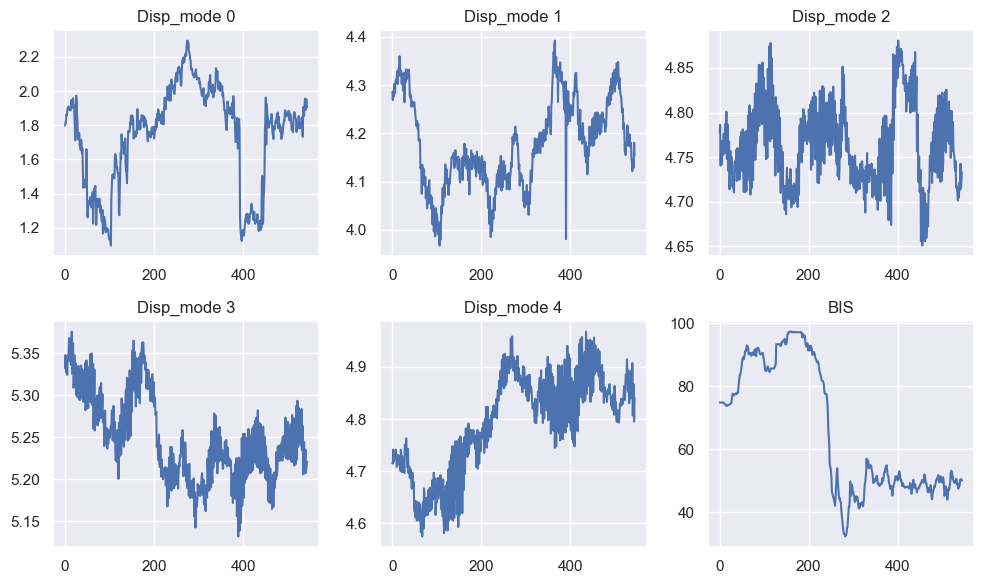

In [22]:
print(f"Number of features:", len(resultsd_4))

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Plot on the first subplot
axes[0, 0].plot(resultsd_0)
axes[0, 0].set_title('Disp_mode 0')

# Plot on the second subplot
axes[0, 1].plot(resultsd_1)
axes[0, 1].set_title('Disp_mode 1')

# Plot on the third subplot
axes[0, 2].plot(resultsd_2)
axes[0, 2].set_title('Disp_mode 2')

axes[1, 0].plot(resultsd_3)
axes[1, 0].set_title('Disp_mode 3')

axes[1, 1].plot(resultsd_4)
axes[1, 1].set_title('Disp_mode 4')

axes[1, 2].plot(bis_windows)
axes[1, 2].set_title('BIS')


# Adjust spacing between subplots
fig.tight_layout()



# Display the figure
plt.show()


### Create Dataframe for each feature and find the correlation


In [23]:
# detf

df_detf = pd.DataFrame({'detf_mode0': resultsdt_0, 'detf_mode1': resultsdt_1, 'detf_mode2': resultsdt_2, 'detf_mode3': resultsdt_3, 'detf_mode4': resultsdt_4})

df_detf['BIS']=bis_windows
#df_detf


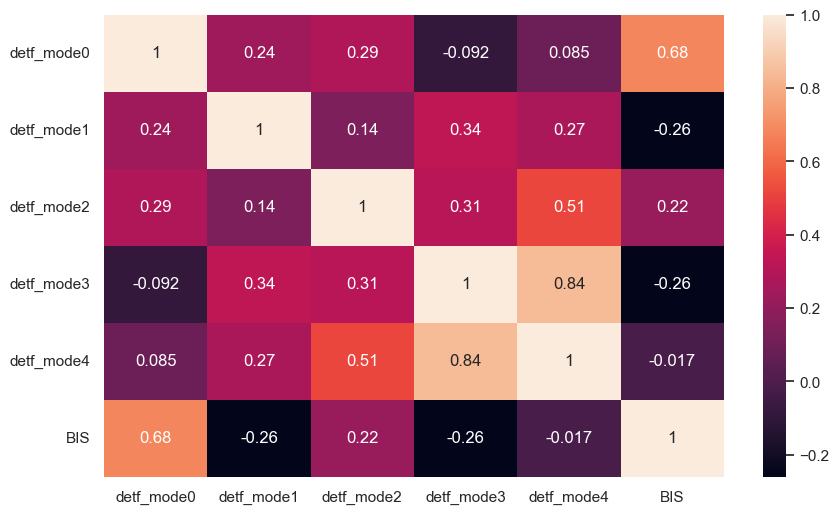

In [31]:
plt.figure(figsize=(10,6))
sns.heatmap(df_detf.corr(), annot = True)
plt.show()

In [24]:
# pet

df_pet = pd.DataFrame({'pet_mode0': resultspet_0, 'pet_mode1': resultspet_1, 'pet_mode2': resultspet_2, 'pet_mode3': resultspet_3, 'pet_mode4': resultspet_4})

df_pet['BIS']=bis_windows
#df_pet



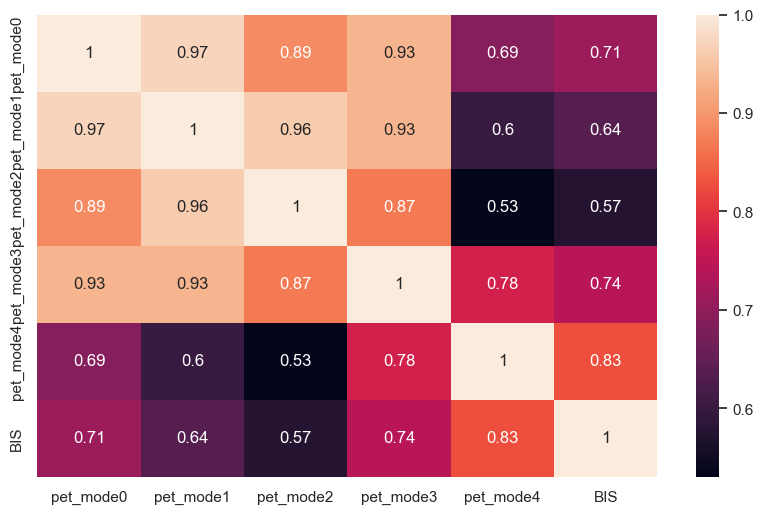

In [33]:
plt.figure(figsize=(10,6))
sns.heatmap(df_pet.corr(), annot = True)
plt.show()

In [25]:
# hm

df_hm = pd.DataFrame({'hm_mode0': resultshm_0, 'hm_mode1': resultshm_1, 'hm_mode2': resultshm_2, 'hm_mode3': resultshm_3, 'hm_mode4': resultshm_4})

df_hm['BIS']=bis_windows
#df_hm


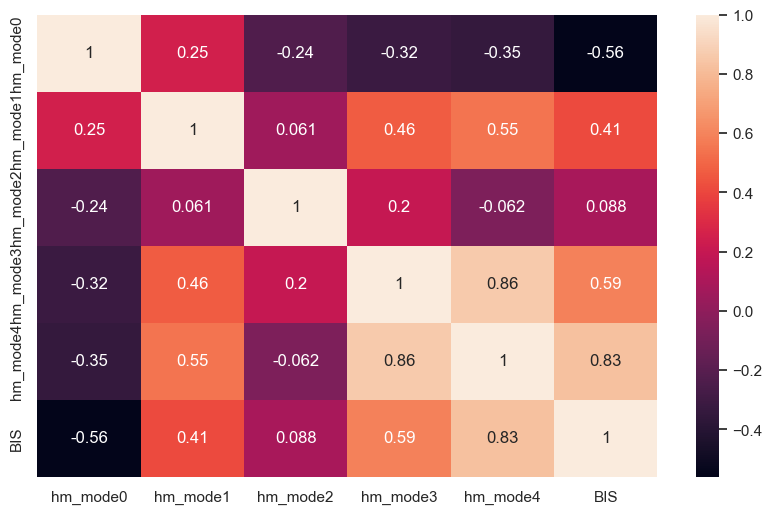

In [35]:
plt.figure(figsize=(10,6))
sns.heatmap(df_hm.corr(), annot = True)
plt.show()

In [26]:
# hc

df_hc = pd.DataFrame({'hc_mode0': resultshc_0, 'hc_mode1': resultshc_1, 'hc_mode2': resultshc_2, 'hc_mode3': resultshc_3, 'hc_mode4': resultshc_4})

df_hc['BIS']=bis_windows
#df_hc


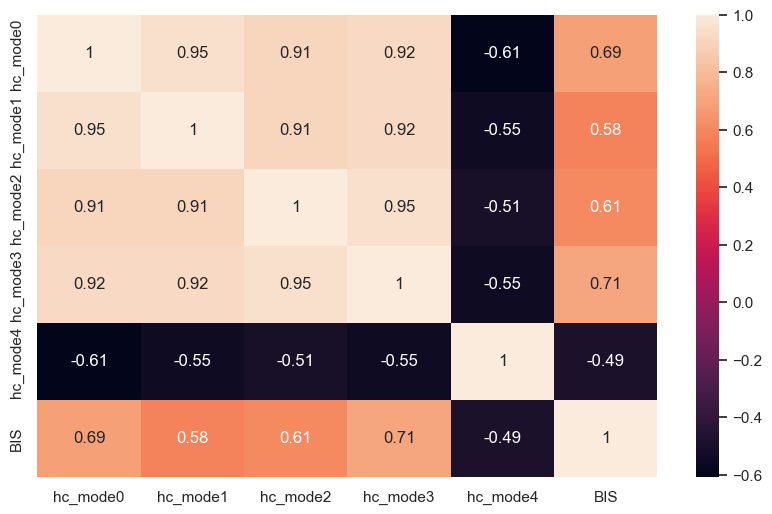

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(df_hc.corr(), annot = True)
plt.show()

In [27]:
# Permutation entropy

df_perm = pd.DataFrame({'Perment_mode0': resultsp_0, 'Perment_mode1': resultsp_1, 'Perment_mode2': resultsp_2, 'Perment_mode3': resultsp_3, 'Perment_mode4': resultsp_4})

df_perm['BIS']=bis_windows
#df_perm

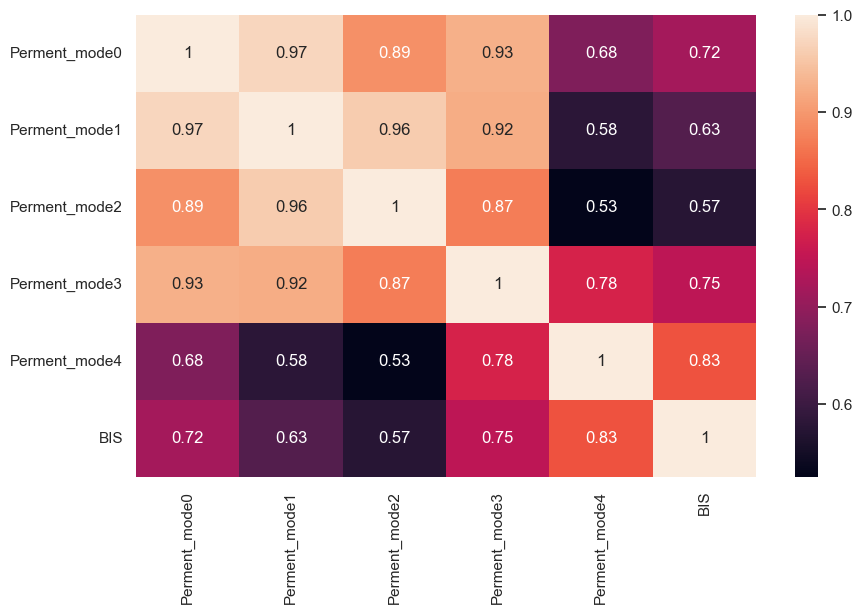

In [39]:
plt.figure(figsize=(10,6))
sns.heatmap(df_perm.corr(), annot = True)
plt.show()

In [28]:
# Dispersion entropy

df_disp = pd.DataFrame({'Disp_mode0': resultsd_0, 'Disp_mode1': resultsd_1, 'Disp_mode2': resultsd_2, 'Disp_mode3': resultsd_3, 'Disp_mode4': resultsd_4})

df_disp['BIS']=bis_windows
#df_disp

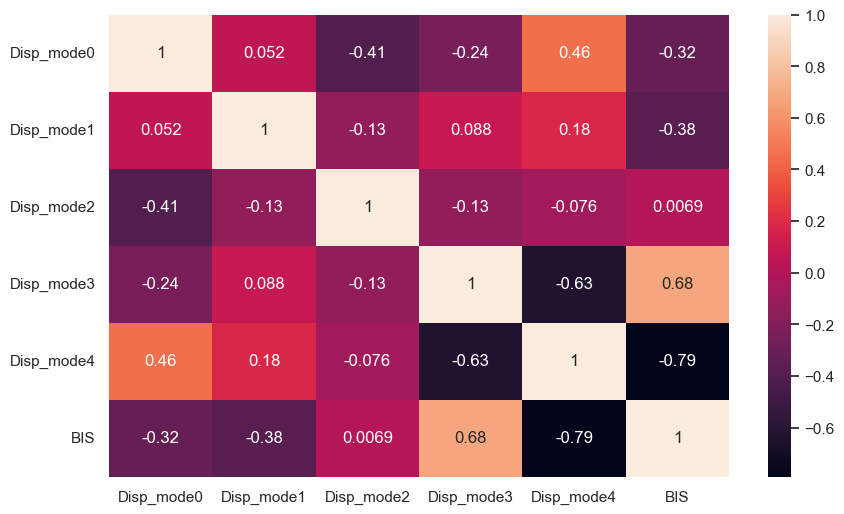

In [41]:
plt.figure(figsize=(10,6))
sns.heatmap(df_disp.corr(), annot = True)
plt.show()

In [29]:
metrics = {}
def plot_regression(data, column, normalize=False):
    
    global metrics
    
    X = data[column].values.reshape(-1, 1)
    #X = X[:, np.newaxis]
    y = data['BIS']

    # Perform regression
    reg = LinearRegression(n_jobs=-1).fit(X, y)
    
    # Predictions
    y_predicted = reg.predict(X)
    
    # Show the score and r2
    #mse = mean_squared_error(y, y_predicted)
    r2 = r2_score(y, y_predicted)
    
    # keep track of metrics
    
    #metrics["{}_mse".format(column)] = mse
    metrics["{}_r2".format(column)] = r2
    
    
    # Plot the graph
    plt.figure(figsize=(8,6))
    plt.scatter(data[column], data['BIS'], label="Data", c="steelblue")
    plt.plot(X, y_predicted, label="Regression", c="red")
    plt.xlabel(column)
    plt.ylabel('BIS')
    plt.legend(loc="upper left")
    plt.show()

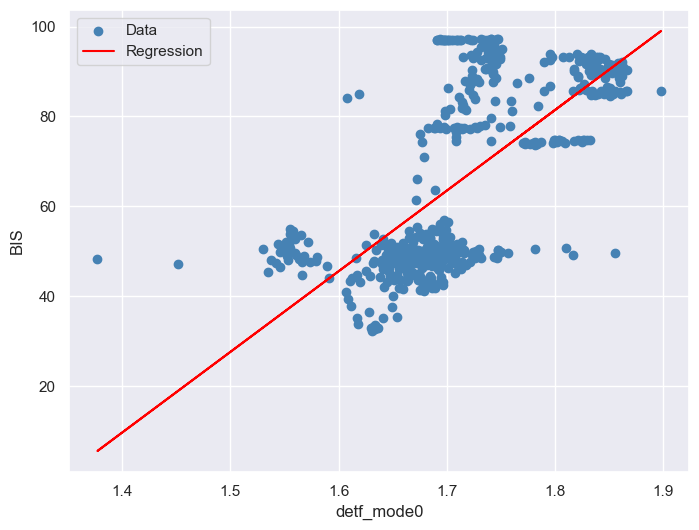

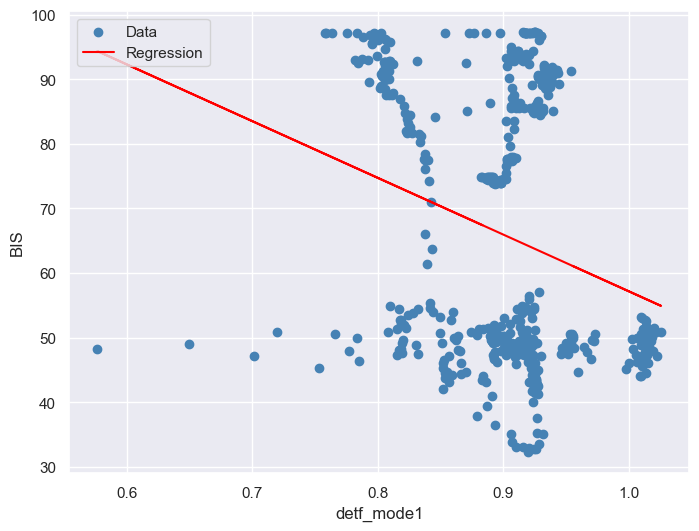

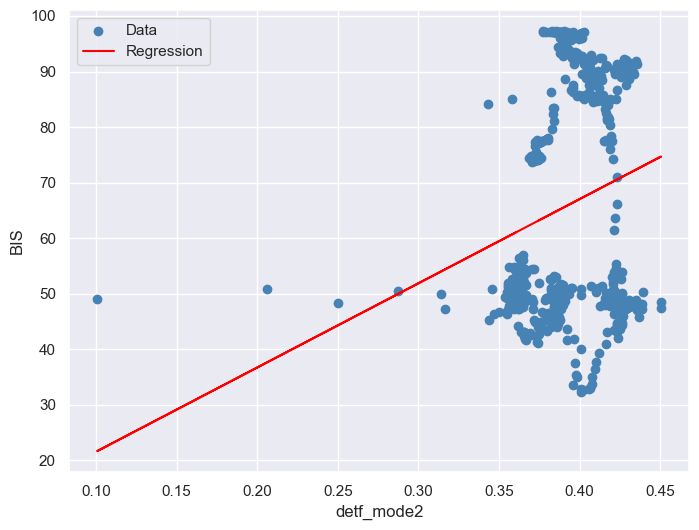

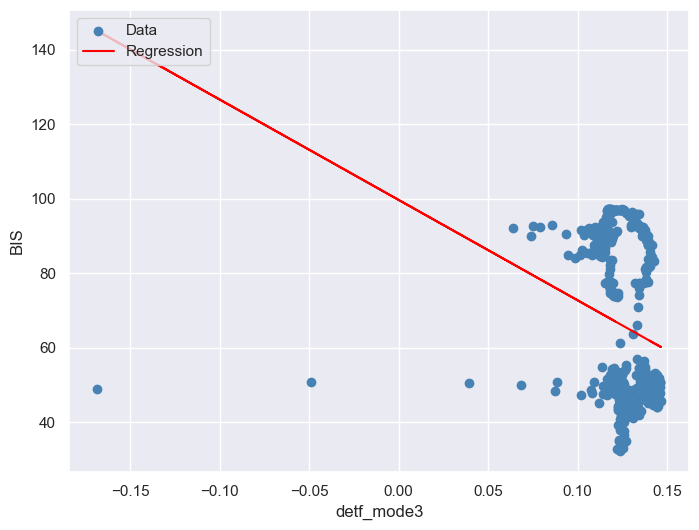

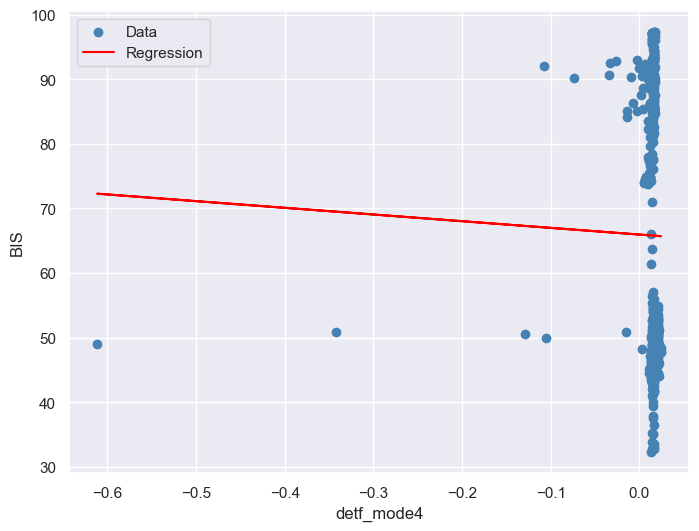

In [30]:
for column in df_detf.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_detf, column)

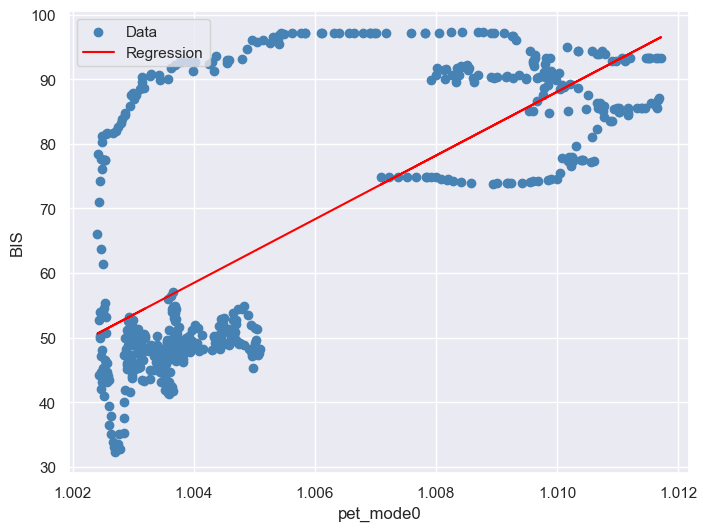

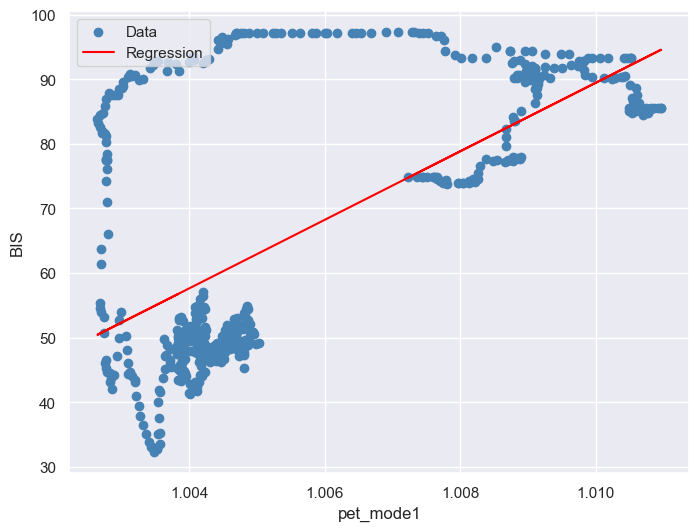

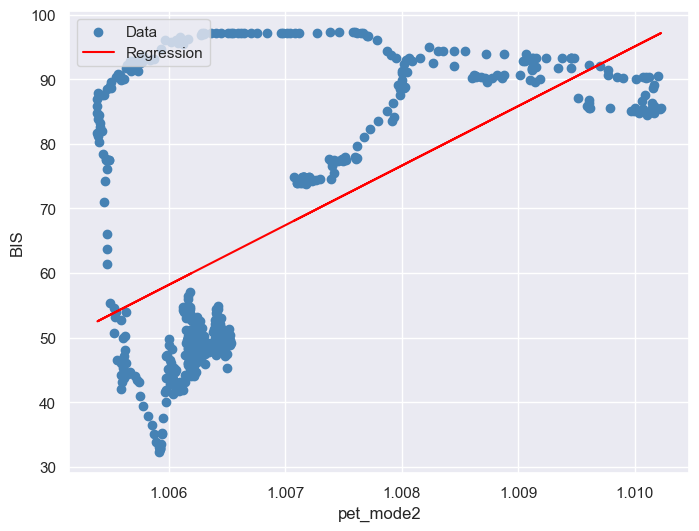

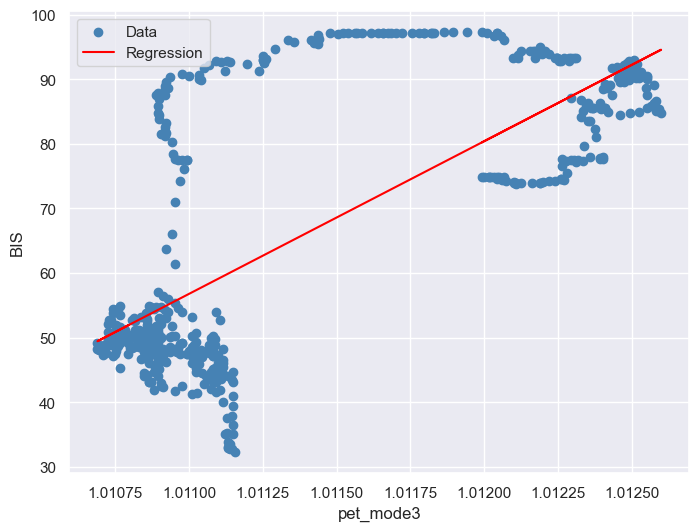

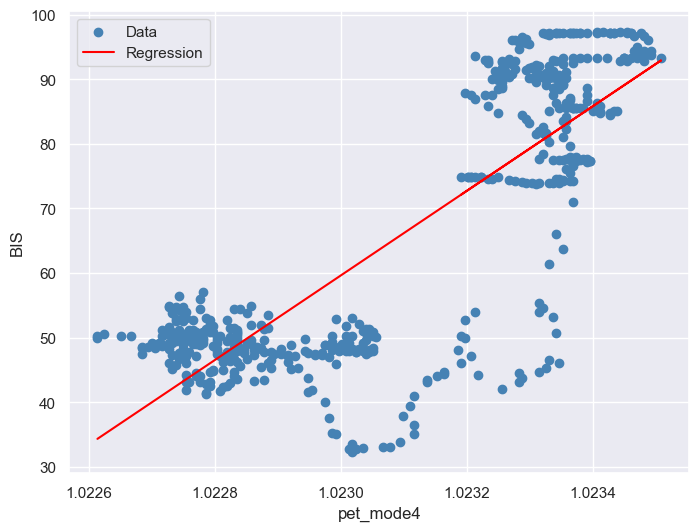

In [31]:
for column in df_pet.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_pet, column)

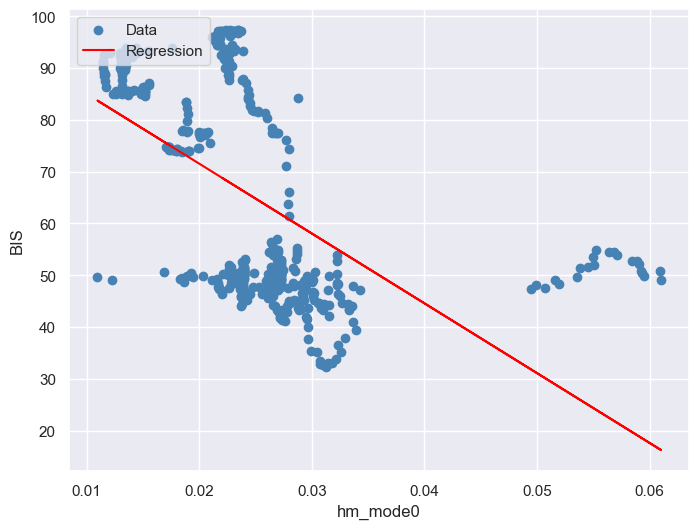

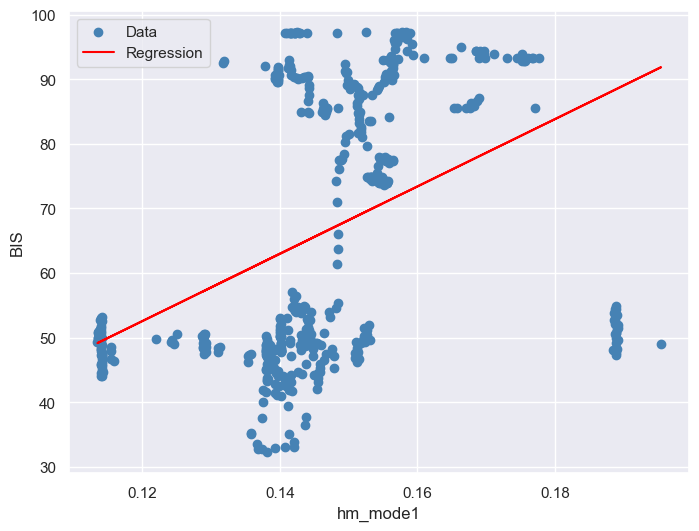

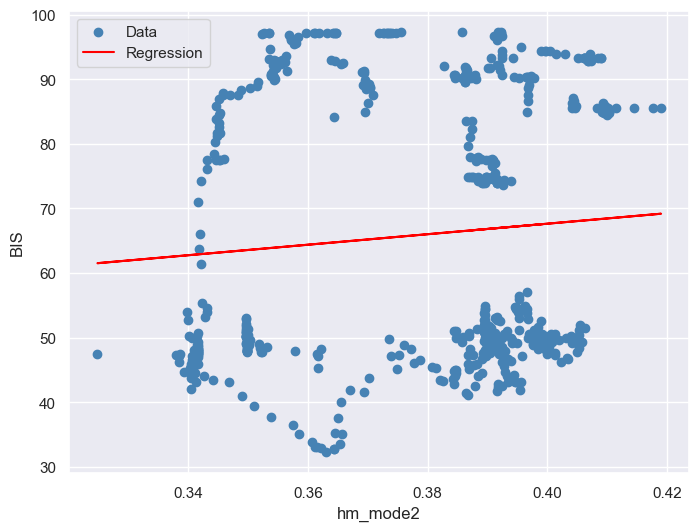

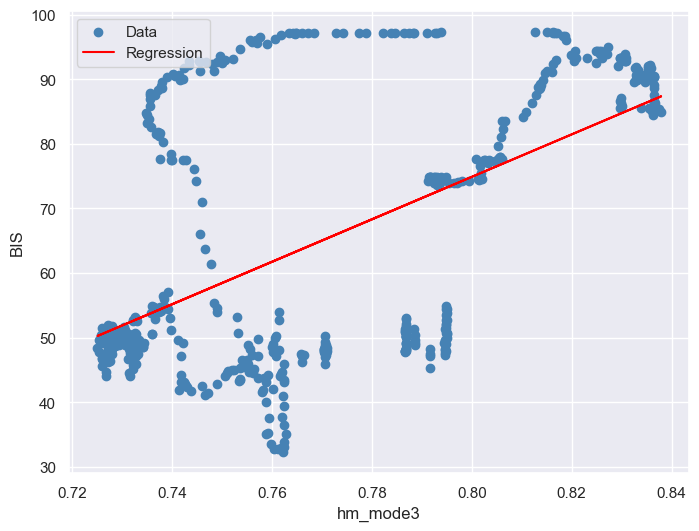

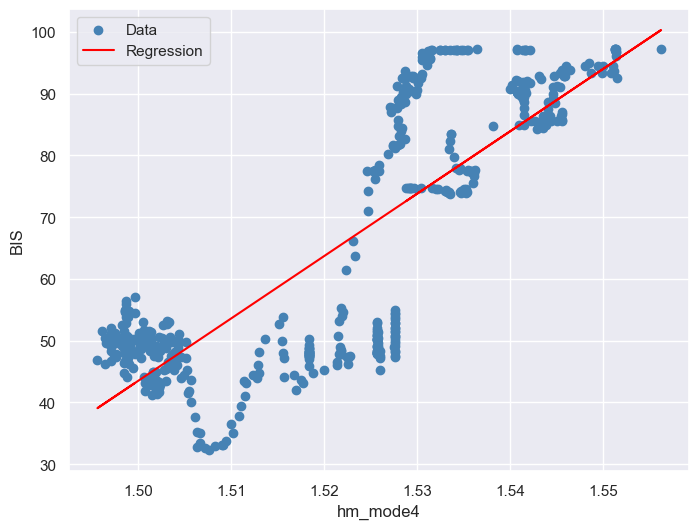

In [32]:
for column in df_hm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hm, column)

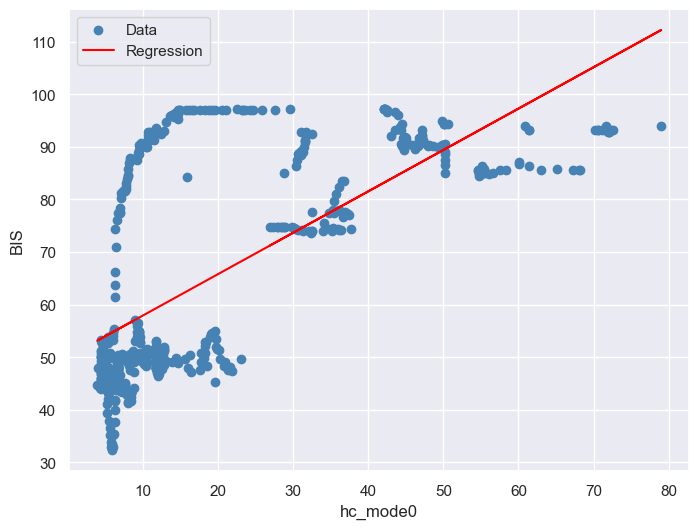

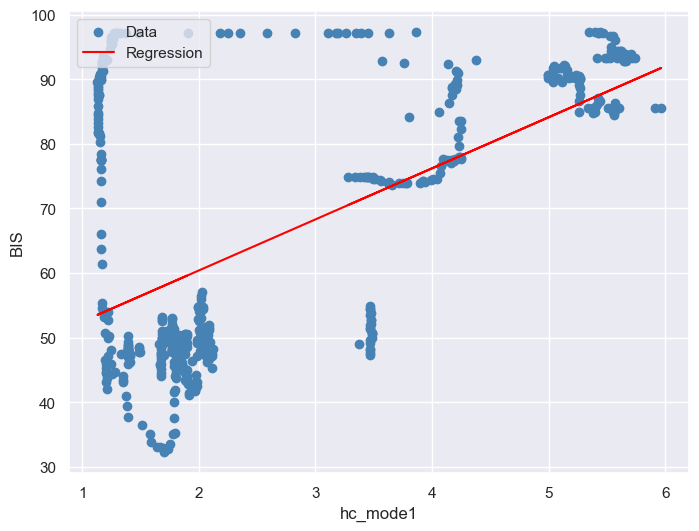

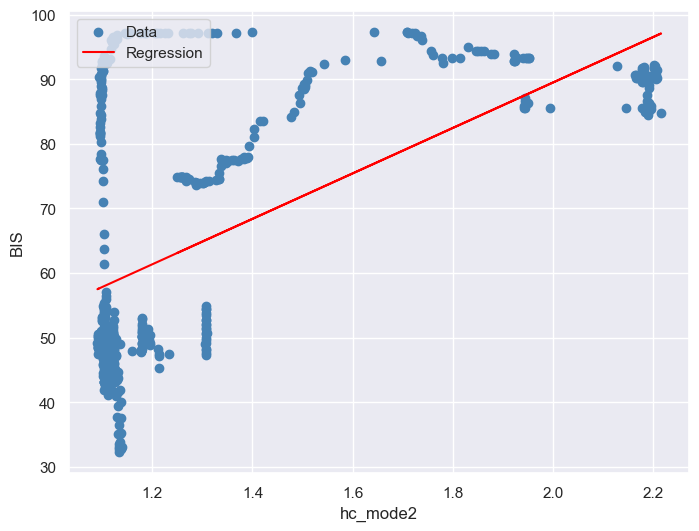

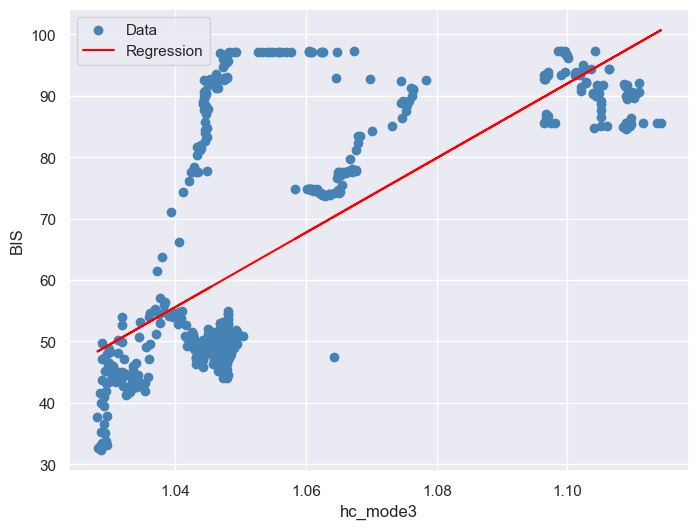

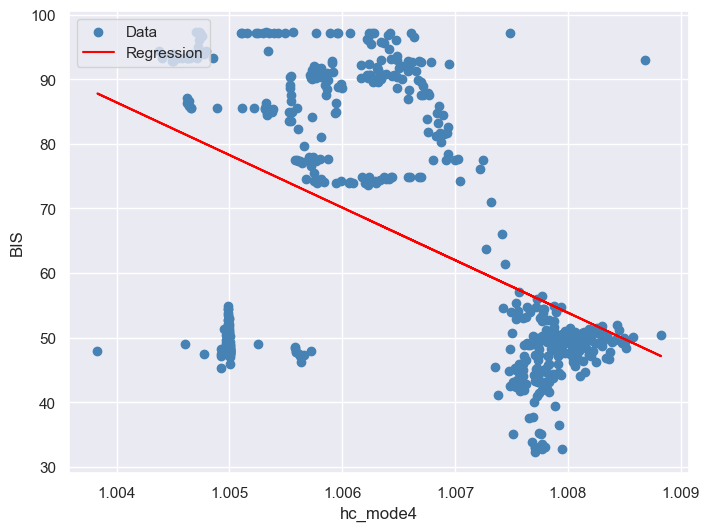

In [33]:
for column in df_hc.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_hc, column)

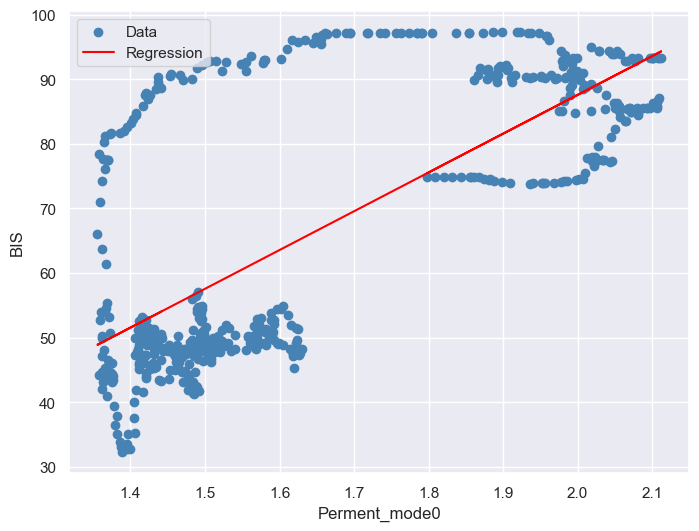

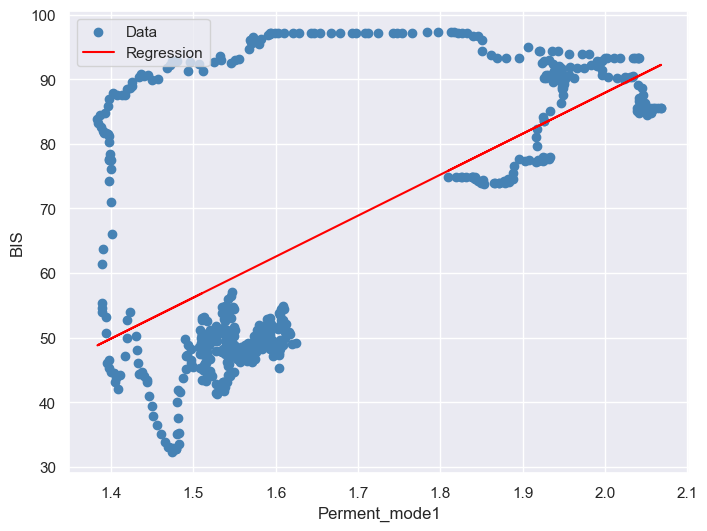

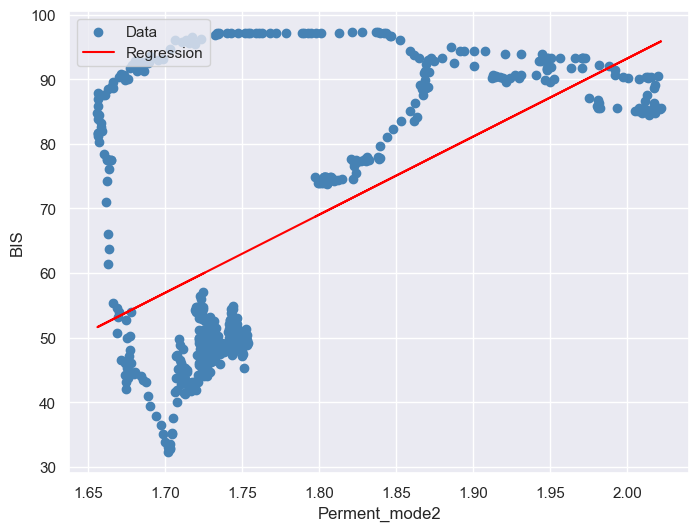

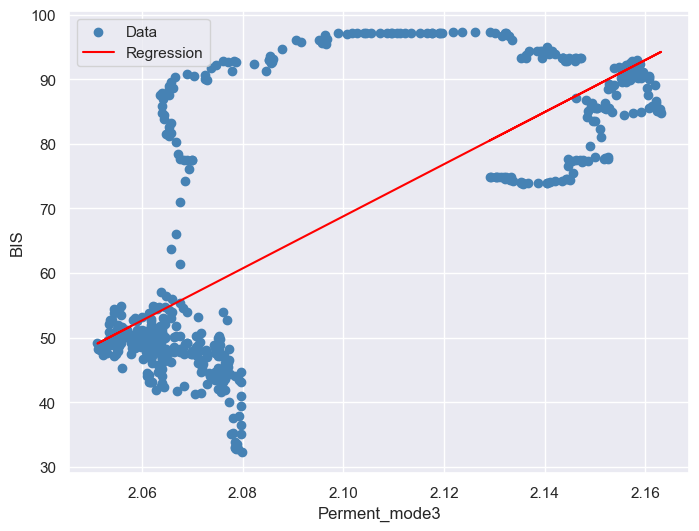

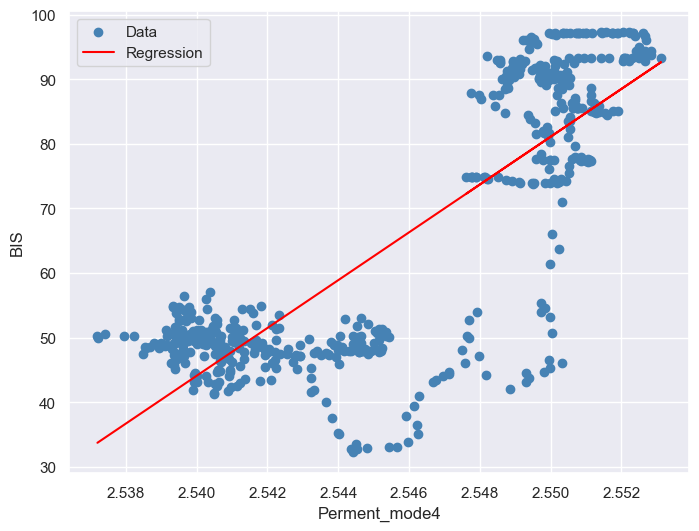

In [34]:
for column in df_perm.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_perm, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

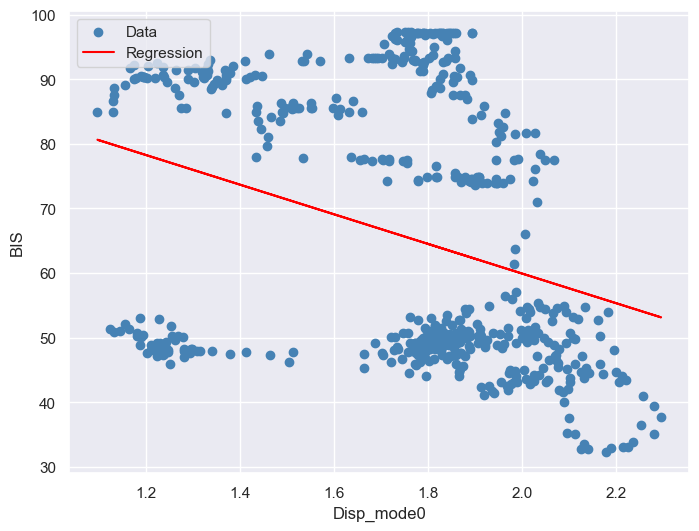

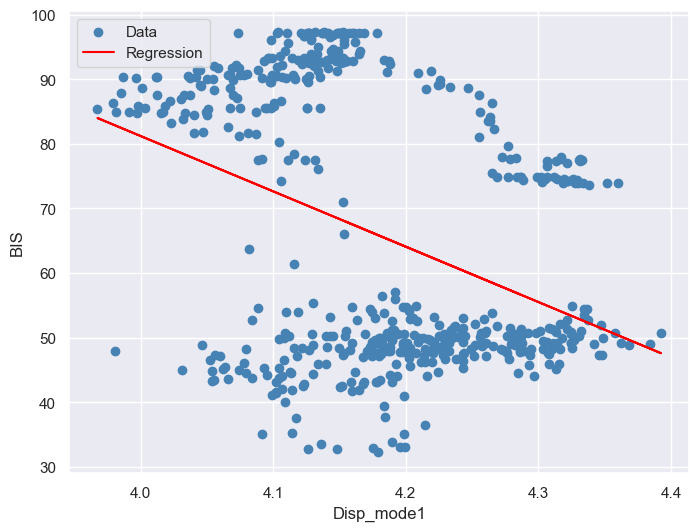

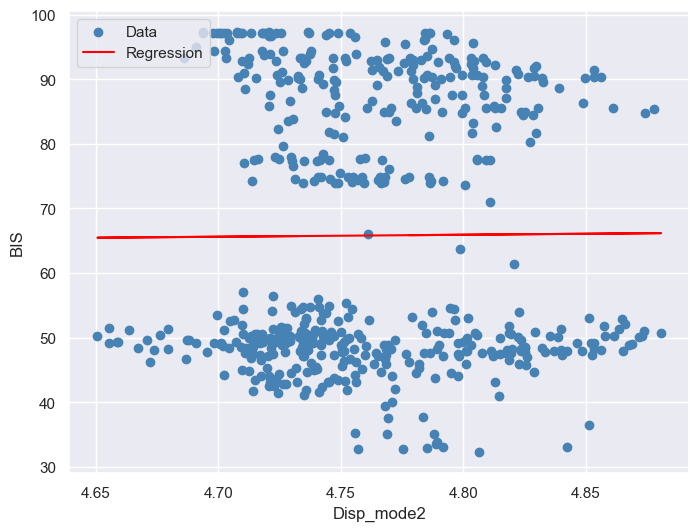

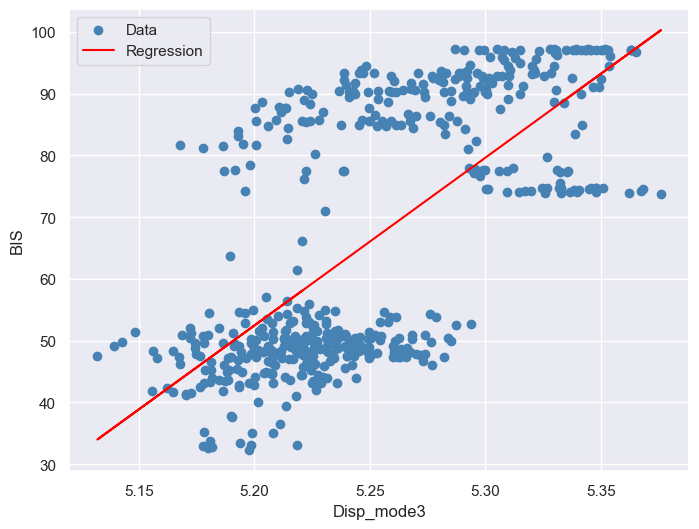

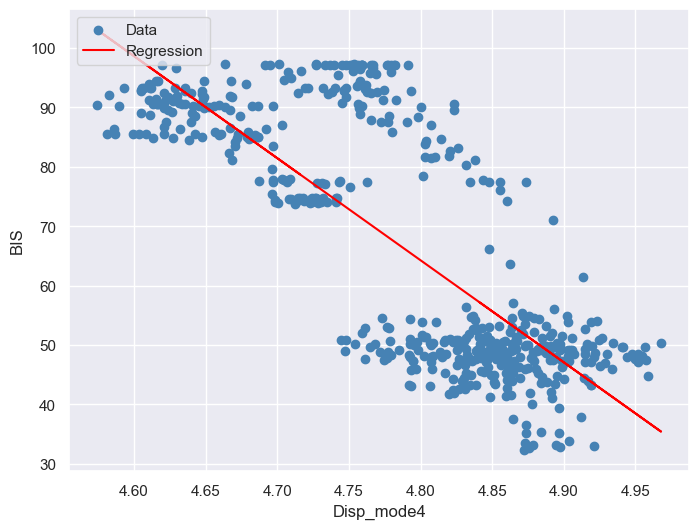

In [35]:
for column in df_disp.columns:
    if column == "BIS":
        continue
        
    plot_regression(df_disp, column)
    
# Metrics
#pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value for value in metrics.values()]})

In [36]:
# Metrics
pd.DataFrame({"Metrics": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})

,Metrics,Values
0,detf_mode0_r2,46.517040
1,detf_mode1_r2,6.658160
2,detf_mode2_r2,4.746051
3,detf_mode3_r2,6.743196
4,detf_mode4_r2,0.027506
5,pet_mode0_r2,50.927560
6,pet_mode1_r2,40.548130
7,pet_mode2_r2,33.025173
8,pet_mode3_r2,55.284579
9,pet_mode4_r2,68.399375


In [37]:
# Metrics
res=pd.DataFrame({"R_squared": [key for key in metrics.keys()], "Values": [value*100 for value in metrics.values()]})
R=res['R_squared']
V=res["Values"]

Text(0.5, 1.0, 'R_squared')

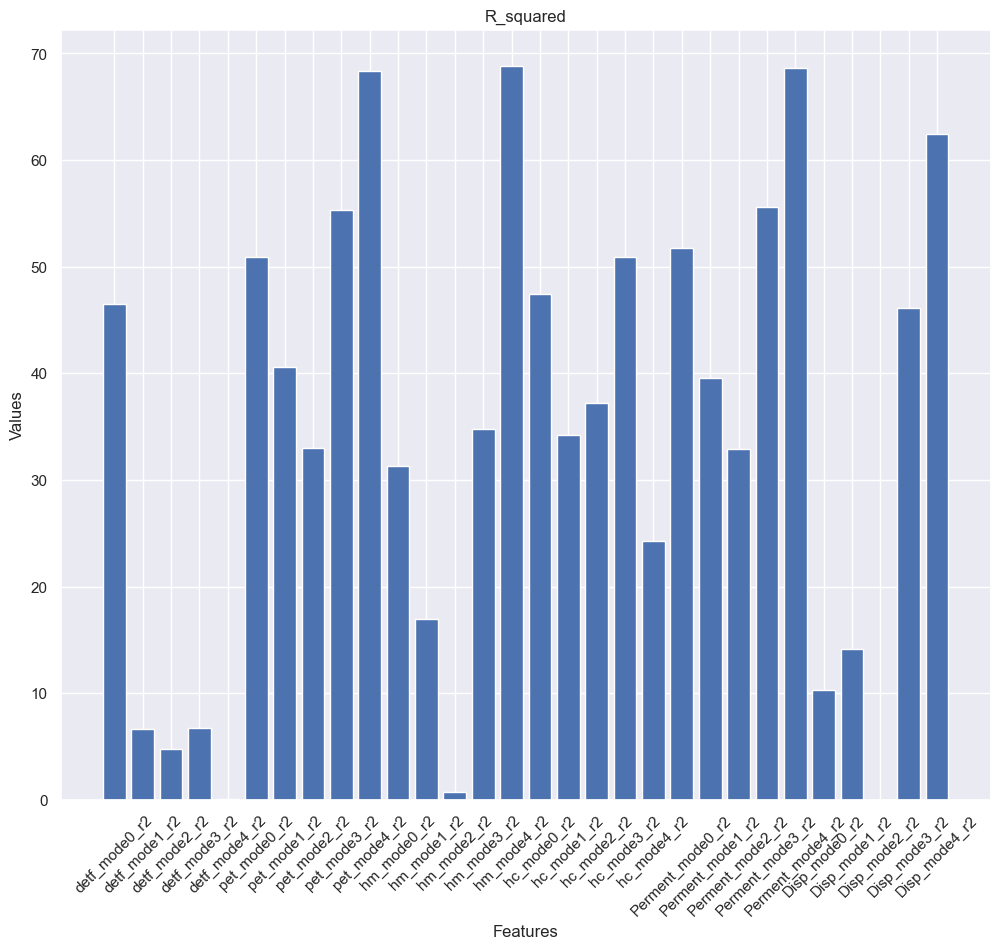

In [38]:
fig = plt.figure(figsize=(12, 10))
plt.bar(R, V)
plt.xticks(rotation=45)
plt.xlabel("Features")
plt.ylabel("Values")    
plt.title("R_squared")   

In [50]:
buk=pd.DataFrame({'Perment_mode4': resultsp_4,'detf_mode0_r2': resultsdt_0, 'pet_mode4_r2': resultspet_4, 'hm_mode4_r2':resultshm_4, 'hc_mode3_r2':resultshc_3, 'Disp_mode4_r2':resultsd_2})

In [51]:
combine=buk[['Perment_mode4', 'detf_mode0_r2', 'pet_mode4_r2', 'hm_mode4_r2', 'hc_mode3_r2', 'Disp_mode4_r2']]
new_y=df_hm['BIS']


mm = LinearRegression(n_jobs=-1).fit(combine, new_y)
    
# Predictions
y_pre = mm.predict(combine)
    
# Show the score and r2
mse = mean_squared_error(new_y, y_pre)
r2 = r2_score(new_y, y_pre)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mm.coef_,mm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [ 1.13803239e+04  8.89191599e+01 -1.77200664e+05  5.34561244e+02
 -3.72352942e+01 -7.40158907e+01], and intercept =151811.9360644508
R_Squared_value for the multiple regression model:  82.33181319667962


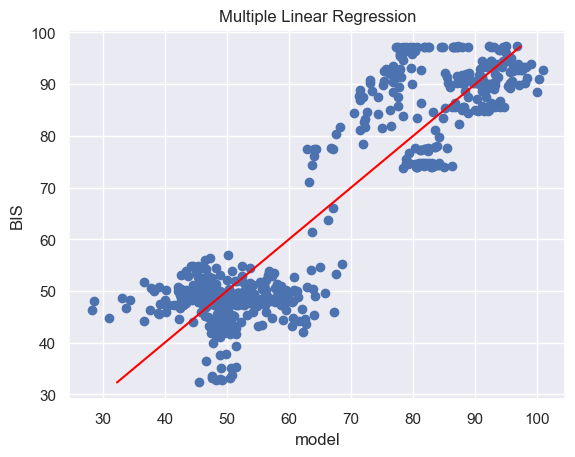

In [52]:
x1=buk['Perment_mode4']
x2=buk['detf_mode0_r2']
x3=buk['pet_mode4_r2']
x4=buk['hm_mode4_r2']
x5=buk['hc_mode3_r2']
x6=buk['Disp_mode4_r2']
y_plot =mm.coef_[0]*x1+mm.coef_[1]*x2+mm.coef_[2]*x3 + mm.coef_[3]*x4+mm.coef_[4]*x5+mm.coef_[5]*x6+mm.intercept_

plt.scatter(y_plot, new_y)
plt.plot( [new_y.min(), new_y.max()], [new_y.min(), new_y.max()], label="Regression", c="red")

plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('model')
plt.show()


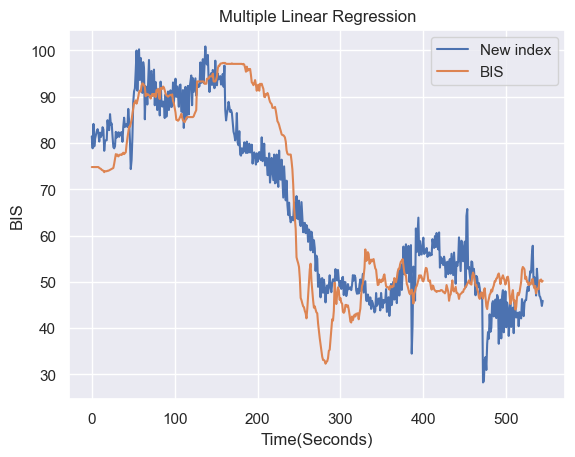

In [53]:
plt.plot(y_plot, label='New index')
plt.plot(new_y,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()

In [47]:
bukk=pd.DataFrame({'Perment_mode4': resultsp_4, 'hm_mode3_r2':resultshm_3, 'hc_mode3_r2':resultshc_3, 'Disp_mode4_r2':resultsd_2})

combined=bukk[['Perment_mode4',  'hm_mode3_r2', 'hc_mode3_r2', 'Disp_mode4_r2']]
new_yy=df_hm['BIS']


mmm = LinearRegression(n_jobs=-1).fit(combined, new_yy)
    
# Predictions
y_pree = mmm.predict(combined)
    
# Show the score and r2
mse = mean_squared_error(new_yy, y_pree)
r2 = r2_score(new_yy, y_pree)
    

print("Multiple regression model Slope = %s, and intercept =%s"%(mmm.coef_,mmm.intercept_))
print('R_Squared_value for the multiple regression model: ', r2*100)

Multiple regression model Slope = [3472.39216207 -242.48046671  510.13490535  -38.61576234], and intercept =-8942.38176719583
R_Squared_value for the multiple regression model:  81.46572190006177


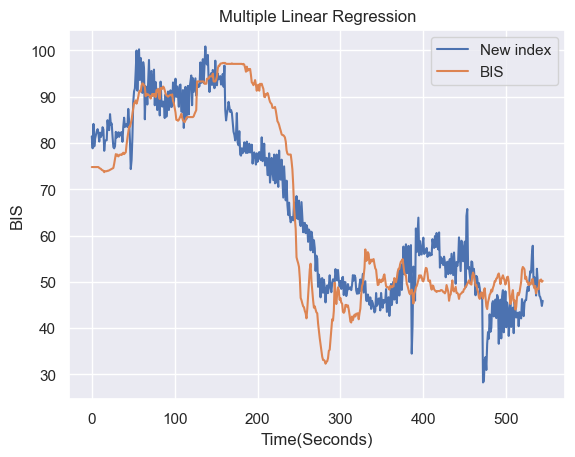

In [49]:
plt.plot(y_plot, label='New index')
plt.plot(bis_windows,label ="BIS")
plt.title('Multiple Linear Regression')
plt.ylabel('BIS')
plt.xlabel('Time(Seconds)')
plt.legend(loc="upper right")
plt.show()